<a href="https://colab.research.google.com/github/rakesh4real/rollmodels/blob/main/keras2onnx.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Helper Functions

In [1]:
"""
## 1. Setup
"""
import matplotlib.pyplot as plt
import time

"""
# 2. Random Image
"""
def get_and_plot_random_image_from(x_test, y_test):
    """
    """
    # get a random image index from the test set
    image_index = int(np.random.randint(0, x_test.shape[0], size=1)[0])
    expected_label = y_test[image_index]
    digit_image = x_test[image_index]
    # and plot it
    plt.title(f'Example {image_index} Label: {expected_label}')
    plt.imshow(digit_image.squeeze(2), cmap='Greys')
    plt.show()
    return digit_image, image_index

"""
# 3. Inference w/o onnx
"""
def infer_w_raw_h5(digit_image, expected_label, model, input_shape, loop_count=40):
    # reshape the image for inference/prediction
    digit_image = digit_image.reshape(1, input_shape[0], input_shape[1], 1)

    # loop `loop_count` times
    start_time = time.time()
    for i in range(loop_count):
        prediction = model.predict(digit_image)
    print(f"Keras inferences with {((time.time() - start_time) / loop_count)} second in average")

    print("="*60)
    print("Prediction probabilities:")
    print(prediction)
    print("="*60)

    predicted_label = prediction.argmax()
    print('Predicted value:', predicted_label)

    is_correct_pred = None
    if (expected_label.argmax() == predicted_label):
      print('Correct prediction')
      is_correct_pred = True
    else:
      print('Wrong prediction')
      is_correct_pred = False

    # can be used for more control (see suggestio where used)
    return is_correct_pred, ((time.time() - start_time) / loop_count)

"""
# 4. Inference w/ onnx

!pip install --quiet -U onnxruntime
!pip install --quiet -U git+https://github.com/microsoft/onnxconverter-common
!pip install --quiet -U git+https://github.com/onnx/keras-onnx
"""
!pip install --quiet -U onnxruntime
!pip install --quiet -U git+https://github.com/microsoft/onnxconverter-common
!pip install --quiet -U git+https://github.com/onnx/keras-onnx

import onnxruntime
import keras2onnx

def h52onnx(model, output_onnxmodel_path='./onnx_model.onnx'):
  print("keras2onnx version is "+keras2onnx.__version__)
  save_name = output_onnxmodel_path.split(".onnx")[0].split("/")[-1] # get name from path
  print(save_name)
  # convert to onnx model
  onnx_model = keras2onnx.convert_keras(model, save_name, debug_mode=1)
  # and save the model in ONNX format
  keras2onnx.save_model(onnx_model, output_onnxmodel_path)


def generate_data_feed_and_sess(digit_image, output_onnxmodel_path):
    # define session (include options using docs if necessary)
    sess_options = onnxruntime.SessionOptions()
    sess = onnxruntime.InferenceSession(output_onnxmodel_path, sess_options)
    # define data
    data = [digit_image.astype(np.float32)]
    # feed data
    input_names = sess.get_inputs()
    feed = dict([(input.name, data[n]) for n, input in enumerate(sess.get_inputs())])
    return feed, sess
    

def infer_w_onnx_runtime(digit_image, expected_label,
                         output_onnxmodel_path='./onnx_model.onnx',
                         loop_count=40):
  # setup
  feed, sess = generate_data_feed_and_sess(digit_image, output_onnxmodel_path)

  # calculate average
  start_time = time.time()
  for i in range(loop_count):
      # note: session is used to make preds
      onnx_predictions = sess.run(None, feed)#[0]
  print("ONNX inferences with %s second in average" %((time.time() - start_time) / loop_count))

  # compare w/ raw h5
  print("="*60)
  print("[onnx]Prediction probabilities:")
  print(onnx_predictions)
  print("="*60)

  print('ONNX predicted value:', onnx_predicted_label)
  if (expected_label.argmax() == onnx_predictions.argmax()):
    print('Correct prediction !')
  else:
    print('Wrong prediction !')


     |████████████████████████████████| 3.8MB 4.5MB/s 
     |████████████████████████████████| 7.4MB 4.4MB/s 
     |████████████████████████████████| 81kB 3.4MB/s 


# Create Keras .h5 Model

- Makes sure input dims is given in first layer

In [2]:
input_shape = (28, 28, 1)

In [ ]:
"""
## Setup
"""
import os
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow
print("TensorFlow version is "+tensorflow.__version__)

"""
## Prepare the data
"""

# Model / data parameters
num_classes = 10

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices
y_train = tensorflow.keras.utils.to_categorical(y_train, num_classes)
y_test = tensorflow.keras.utils.to_categorical(y_test, num_classes)

"""
## Build the model
"""

model = keras.Sequential(
    [
        keras.Input(shape=input_shape), # !NOTE: input shape must be defined @beg to avoid onnx errors
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

"""
## Train the model
"""

os.makedirs("keras_saved_model", exist_ok=True)
checkpoint_filepath = 'keras_saved_model/model.h5'
model_checkpoint_callback = tensorflow.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False, # else, error
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)



batch_size = 128
epochs = 10
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1, callbacks=[model_checkpoint_callback])

"""
## Evaluate the trained model
"""

score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

TensorFlow version is 2.3.0
11493376/11490434 [==============================] - 0s 0us/step
x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dropout (Dropout)     

# Load and eval best.h5 model

In [8]:
# best models
model = tensorflow.keras.models.load_model(checkpoint_filepath)

# eval
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.030610736459493637
Test accuracy: 0.989300012588501


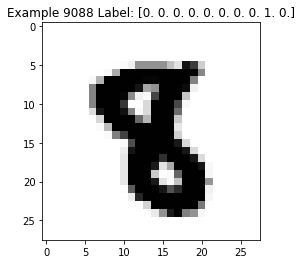

Keras inferences with 0.02729431390762329 second in average
Prediction probabilities:
[[2.4317370e-10 3.8996895e-08 7.6472270e-07 2.5567792e-06 1.3831500e-08
  1.1546534e-05 1.0787697e-07 7.6338917e-09 9.9998486e-01 1.6524099e-07]]
Predicted value: 8
Correct prediction


(True, 0.02731964588165283)

In [9]:
# a. get random image
digit_image, digit_idx = get_and_plot_random_image_from(x_test, y_test)

# b. loop inference for avg. inference time
infer_w_raw_h5(digit_image, expected_label=y_test[digit_idx],
               model=model, input_shape=input_shape)

# SUGGESTION: For more control, as this is for single, image, 
# Go one step further by putiing the above two functions 
# in loop as well and take average

# Conversion from Keras to ONNX


In [10]:
h52onnx(model, "./keras-mnist-optimized.onnx") # saves in curdir

tf executing eager_mode: True
tf.keras model eager_mode: False
Processing a keras layer - (dense: <class 'tensorflow.python.keras.layers.core.Dense'>)
	output: dense/Softmax_2:0
	input : dropout/cond_2/Identity:0
Processing a keras layer - (dropout: <class 'tensorflow.python.keras.layers.core.Dropout'>)
	output: dropout/cond_2/Identity:0
	input : flatten/Reshape_2:0
Processing a keras layer - (flatten: <class 'tensorflow.python.keras.layers.core.Flatten'>)
	output: flatten/Reshape_2:0
	input : max_pooling2d_1/MaxPool_2:0
Processing a keras layer - (max_pooling2d_1: <class 'tensorflow.python.keras.layers.pooling.MaxPooling2D'>)
	output: max_pooling2d_1/MaxPool_2:0
	input : conv2d_1/Relu_2:0
Processing a keras layer - (conv2d_1: <class 'tensorflow.python.keras.layers.convolutional.Conv2D'>)
	output: conv2d_1/Relu_2:0
	input : max_pooling2d/MaxPool_2:0
Processing a keras layer - (max_pooling2d: <class 'tensorflow.python.keras.layers.pooling.MaxPooling2D'>)
	output: max_pooling2d/MaxPool_2

keras2onnx version is 1.7.1
keras-mnist-optimized
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1600)              0         
_________________________________________________________________
dense 

# Evaluate the ONNX's Model Performance

In [19]:

import keras2onnx
print("keras2onnx version is "+keras2onnx.__version__)
# convert to onnx model
onnx_model = keras2onnx.convert_keras(model, 'mnist-onnx', debug_mode=1)
output_model_path = "./mnist-model.onnx"
# and save the model in ONNX format
keras2onnx.save_model(onnx_model, output_model_path)


import onnxruntime
sess_options = onnxruntime.SessionOptions()
sess = onnxruntime.InferenceSession(output_model_path, sess_options)
data = [digit_image.astype(np.float32)]
input_names = sess.get_inputs()
feed = dict([(input.name, data[n]) for n, input in enumerate(sess.get_inputs())])



tf executing eager_mode: True
tf.keras model eager_mode: False
Processing a keras layer - (dense: <class 'tensorflow.python.keras.layers.core.Dense'>)
	output: dense/Softmax_2:0
	input : dropout/cond_2/Identity:0
Processing a keras layer - (dropout: <class 'tensorflow.python.keras.layers.core.Dropout'>)
	output: dropout/cond_2/Identity:0
	input : flatten/Reshape_2:0
Processing a keras layer - (flatten: <class 'tensorflow.python.keras.layers.core.Flatten'>)
	output: flatten/Reshape_2:0
	input : max_pooling2d_1/MaxPool_2:0
Processing a keras layer - (max_pooling2d_1: <class 'tensorflow.python.keras.layers.pooling.MaxPooling2D'>)
	output: max_pooling2d_1/MaxPool_2:0
	input : conv2d_1/Relu_2:0
Processing a keras layer - (conv2d_1: <class 'tensorflow.python.keras.layers.convolutional.Conv2D'>)
	output: conv2d_1/Relu_2:0
	input : max_pooling2d/MaxPool_2:0
Processing a keras layer - (max_pooling2d: <class 'tensorflow.python.keras.layers.pooling.MaxPooling2D'>)
	output: max_pooling2d/MaxPool_2

keras2onnx version is 1.7.1
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)               

In [20]:
start_time = time.time()
for i in range(loop_count):
    onnx_predicted_label = sess.run(None, feed)[0].argmax()
print("ONNX inferences with %s second in average" %((time.time() - start_time) / loop_count))

print('ONNX predicted value:', onnx_predicted_label)
if (expected_label == onnx_predicted_label):
  print('Correct prediction !')
else:
  print('Wrong prediction !')

if (predicted_label == onnx_predicted_label):
  print("The ONNX's and keras' prediction are matching !")
else:
  print("The ONNX's and keras' prediction does not match !")


InvalidArgument: ignored